In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from keras.utils import to_categorical
import keras
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/HistoricalData_1762505162519.csv')

In [ ]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,11/06/2025,$284.75,37173650,$285.33,$288.35,$281.14
1,11/05/2025,$284.31,31010300,$278.87,$286.415,$277.34
2,11/04/2025,$277.54,30078370,$276.75,$281.27,$276.26
3,11/03/2025,$283.72,29786000,$282.175,$285.53,$279.80
4,10/31/2025,$281.19,39267950,$283.21,$286.00,$277.03


In [ ]:
df['Close'] = df['Close/Last'].map( lambda x : float(x.replace('$', '')))
df['Date'] = pd.to_datetime(df['Date'])
df.High = df.High.map( lambda x : float(x.replace('$', '')))
df.Open = df.Open.map( lambda x : float(x.replace('$', '')))
df.Low = df.Low.map( lambda x : float(x.replace('$', '')))
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date', ascending=True)

In [ ]:
df.head()

,Date,Close/Last,Volume,Open,High,Low,Close
2513,2015-11-09,$37.7385,35533340,37.926,38.1650,37.4555,37.7385
2512,2015-11-10,$37.913,29797020,37.674,38.0300,37.4205,37.9130
2511,2015-11-11,$38.2625,41868440,38.119,38.4540,37.9875,38.2625
2510,2015-11-12,$37.8265,35367440,38.009,38.2899,37.7930,37.8265
2509,2015-11-13,$37.0035,48122620,37.702,37.7665,36.9735,37.0035


In [ ]:
import matplotlib.pyplot as plt

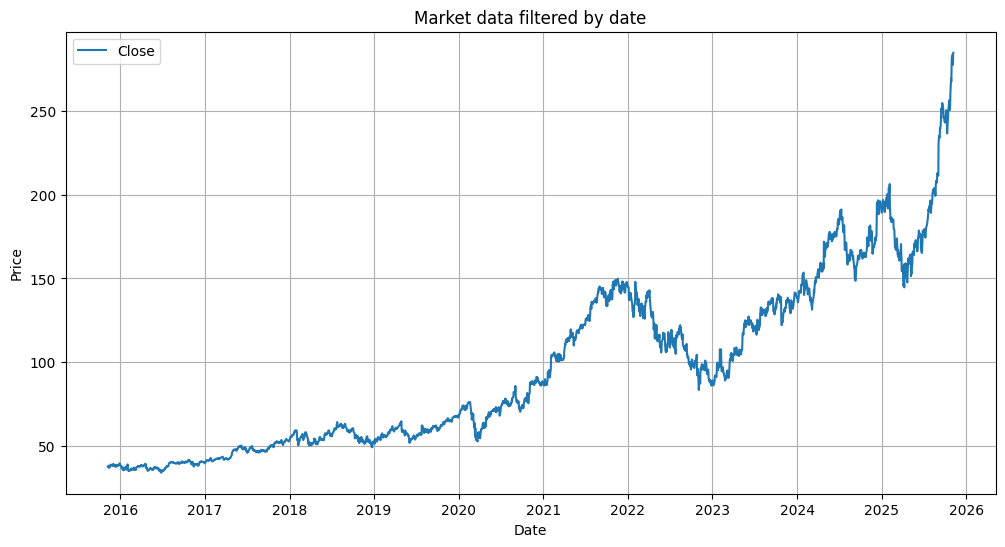

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"], label="Close")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Market data filtered by date")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, Accuracy, CategoricalCrossentropy
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Dense, Dropout,ConvLSTM1D, Flatten

In [ ]:
feature_cols = ['Open','High','Low','Close','Volume']
target_col = 'Close'
close_index = feature_cols.index(target_col)

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[feature_cols].values.astype('float32'))

In [ ]:
SEQ_LEN = 200
HORIZON_SHORT = 1
HORIZON_LONG = 5
def create_sequences(data_scaled, seq_len=30, horizon=1, target_index=close_index):
    X,y = [],[]
    n = len(data_scaled)
    for i in range(n - seq_len - horizon + 1):
        X.append(data_scaled[i:i+seq_len])
        y_seq = data_scaled[i+seq_len:i+seq_len+horizon, target_index]
        if horizon == 1:
            y.append(y_seq[0])
        else:
            y.append(y_seq)
    return np.array(X), np.array(y)

In [ ]:
X_s, y_s = create_sequences(data_scaled, SEQ_LEN, HORIZON_SHORT)
X_l, y_l = create_sequences(data_scaled, SEQ_LEN, HORIZON_LONG)

def time_split(X,y,train_frac=0.7):
    n = len(X)
    split = int(n*train_frac)
    return X[:split], X[split:], y[:split], y[split:]

Xtr_s, Xte_s, ytr_s, yte_s = time_split(X_s,y_s)
Xtr_l, Xte_l, ytr_l, yte_l = time_split(X_l,y_l)

In [ ]:
print("Shapes court-terme:", Xtr_s.shape, ytr_s.shape)
print("Shapes long-terme:", Xtr_l.shape, ytr_l.shape)

Shapes court-terme: (1619, 200, 5) (1619,)
Shapes long-terme: (1617, 200, 5) (1617, 5)


In [ ]:
def invert_scaling(y_scaled):
    y_scaled = np.array(y_scaled).reshape(-1)
    arr = np.zeros((len(y_scaled), len(feature_cols)))
    arr[:, close_index] = y_scaled
    return scaler.inverse_transform(arr)[:, close_index]

def evaluate_model(model, X_test, y_test, horizon=1, name=""):
    y_pred = model.predict(X_test, verbose=0)

    if horizon == 1:
        y_pred = y_pred.reshape(-1)
        y_test = y_test.reshape(-1)
        ytrue = invert_scaling(y_test)
        ypred = invert_scaling(y_pred)
    else:
        y_pred = np.array(y_pred)
        ytrue = np.column_stack([invert_scaling(y_test[:,i]) for i in range(horizon)])
        ypred = np.column_stack([invert_scaling(y_pred[:,i]) for i in range(horizon)])

    rmse = math.sqrt(np.mean((ypred - ytrue) ** 2))
    mae = np.mean(np.abs(ypred - ytrue))
    print(f"{name} -> RMSE={rmse:.4f}, MAE={mae:.4f}")
    return ytrue, ypred, rmse, mae


In [ ]:
def build_lstm(input_shape, horizon=1):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(64),
        Dropout(0.2),
        Dense(32),
        Dropout(0.2),
        Dense(horizon)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape, horizon=1):
    model = Sequential([
        GRU(128, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(64),
        Dropout(0.2),
        Dense(32),
        Dropout(0.2),
        Dense(horizon)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_conv1d_lstm(input_shape, horizon=1):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128),
        Dropout(0.2),
        Dense(64),
        Dropout(0.2),
        Dense(horizon)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


--- Training LSTM (1-step) ---
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.1309 - val_loss: 0.0327
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0221 - val_loss: 0.0755
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0214 - val_loss: 0.0530
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0188 - val_loss: 0.0120
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0155 - val_loss: 0.0211
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0144 - val_loss: 0.0090
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0132 - val_loss: 0.0150
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0126 - val_loss: 0.0112
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0121 - val_loss: 0.0116
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0117 - val_loss: 0.0136
Epoch 12/20
51/51 ━━━━━━━━━━━━

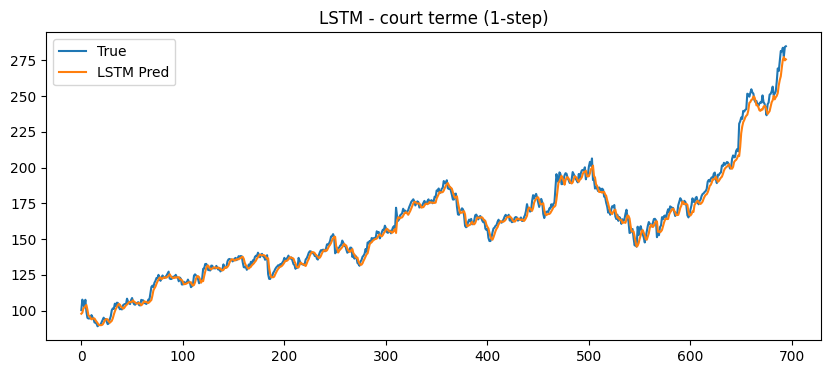


--- Training GRU (1-step) ---
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.2297 - val_loss: 0.0196
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0305 - val_loss: 0.0113
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0208 - val_loss: 0.0164
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0192 - val_loss: 0.0097
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0181 - val_loss: 0.0100
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0181 - val_loss: 0.0198
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0166 - val_loss: 0.0083
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0140 - val_loss: 0.0134
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0142 - val_loss: 0.0077
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0147 - val_loss: 0.0052
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0124 - val_loss: 0.0060
Epoch 12/20
51/51 ━━━━━━━━━━━━━━

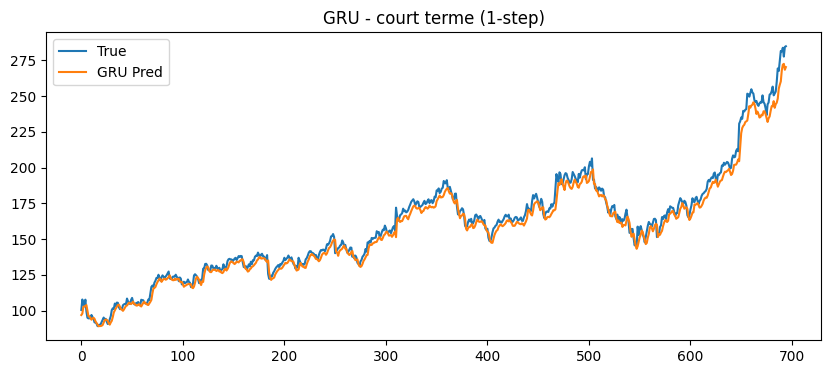


--- Training Conv1D+LSTM (1-step) ---
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.8740 - val_loss: 0.1636
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2101 - val_loss: 0.4331
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1076 - val_loss: 0.3283
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0745 - val_loss: 0.4406
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0642 - val_loss: 0.4741
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0569 - val_loss: 0.3611
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0501 - val_loss: 0.3694
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0508 - val_loss: 0.3311
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0439 - val_loss: 0.4017
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0373 - val_loss: 0.3415
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0409 - val_loss: 0.2434
Epoch 12/20
51/51 ━━━━━

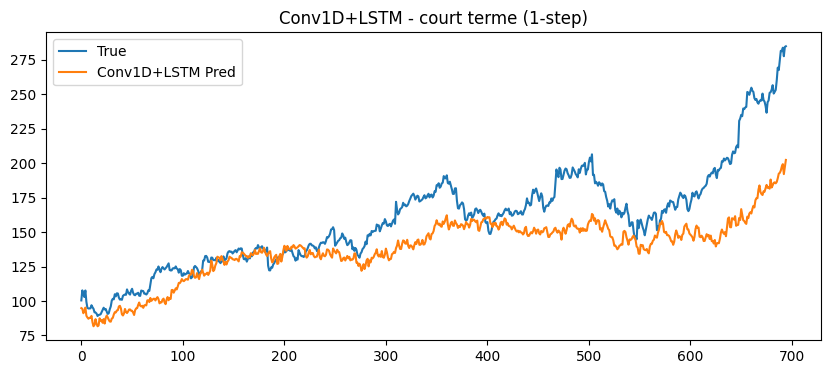

In [ ]:
input_shape = (SEQ_LEN, len(feature_cols))

models = {
    "LSTM": build_lstm(input_shape, horizon=1),
    "GRU": build_gru(input_shape, horizon=1),
    "Conv1D+LSTM": build_conv1d_lstm(input_shape, horizon=1),
}

results = []
for name, model in models.items():
    print(f"\n--- Training {name} (1-step) ---")
    model.fit(Xtr_s, ytr_s, validation_data=(Xte_s, yte_s), epochs=20, batch_size=32, verbose=1)
    ytrue, ypred, rmse, mae = evaluate_model(model, Xte_s, yte_s, horizon=1, name=name)
    results.append((name, rmse, mae))
    # plot
    plt.figure(figsize=(10,4))
    plt.plot(ytrue, label="True")
    plt.plot(ypred, label=f"{name} Pred")
    plt.title(f"{name} - court terme (1-step)")
    plt.legend()
    plt.show()


--- Multi-jours (5steps) ---
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 0.1709 - val_loss: 0.0563
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0459 - val_loss: 0.0464
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0328 - val_loss: 0.0533
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0289 - val_loss: 0.0413
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0274 - val_loss: 0.0414
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0241 - val_loss: 0.0396
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0229 - val_loss: 0.0219
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0213 - val_loss: 0.0188
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0214 - val_loss: 0.0378
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0207 - val_loss: 0.0413
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0196 - val_loss: 0.0267
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.

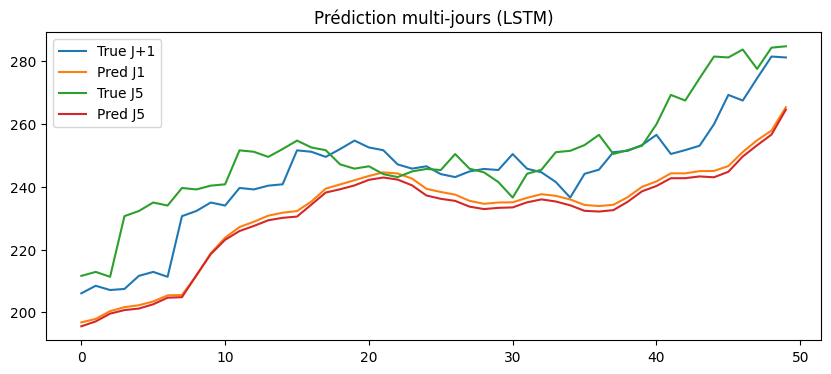

In [ ]:
print("\n--- Multi-jours ("+ str(HORIZON_LONG) +"steps) ---")
multi_model = build_lstm(input_shape, horizon=HORIZON_LONG)
multi_model.fit(Xtr_l, ytr_l, validation_data=(Xte_l, yte_l), epochs=20, batch_size=64, verbose=1)
ytrue_l, ypred_l, rmse_l, mae_l = evaluate_model(multi_model, Xte_l, yte_l, horizon=HORIZON_LONG, name="LSTM-multi")

# plot prédictions multi-jours
plt.figure(figsize=(10,4))
plt.plot(ytrue_l[-50:,0], label="True J+"+str(HORIZON_SHORT))
plt.plot(ypred_l[-50:,0], label="Pred J"+str(HORIZON_SHORT))
plt.plot(ytrue_l[-50:,4], label="True J"+str(HORIZON_LONG))
plt.plot(ypred_l[-50:,4], label="Pred J"+str(HORIZON_LONG))
plt.title("Prédiction multi-jours (LSTM)")
plt.legend()
plt.show()

# Exercice 2 : Génération de texte car2car

In [ ]:
alice = ""
with open("/content/alice.txt") as f :
  alice = f.read()
alice = alice[1::]
alice = alice.lower()
oh_size = len(set(alice))
reference = list(set(alice))
oh_size

63

In [ ]:
# On enlève le premier caractère qui est un caractère start of file
alice_array = list(alice[1::])

In [ ]:
def char2int(txt : list[chr] )-> list:
  return [reference.index(x) for x in txt]
def int2char(encoded_txt : list)-> list:
  return [reference[x] for x in encoded_txt]
def construct_n_grams(encoded_array, n):
  window = n+1
  result = [encoded_array[i:i+n] for i in range(len(encoded_array)-n)]
  X,y = [],[]
  for i in range(len(result)):
    X.append(result[i][:-1])
    y.append(result[i][-1])
  return X,y


In [ ]:
encoded_alice = char2int(alice_array)

In [ ]:
X, y = construct_n_grams(encoded_alice, 50)

In [ ]:
y_oh = tf.one_hot(y,oh_size)

In [ ]:
def train_test_split_ordered (X,y,test_size=0.25):
  n = len(X)
  split = int(n*(1-test_size))
  return X[:split], X[split:], y[:split], y[split:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split_ordered(X,y_oh)

In [ ]:
def build_lstm_car2car(n_grams_size=50, dropout=0.2, layer_size=128,hidden_layers=2) -> keras.Sequential:
  model = keras.Sequential()
  model.add(keras.layers.Embedding(oh_size, layer_size))
  for _ in range(hidden_layers):
    model.add(keras.layers.LSTM(layer_size, return_sequences=True if _ < hidden_layers -1 else False))
    model.add(keras.layers.Dropout(dropout))
  model.add(keras.layers.Dense(oh_size, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
  return model

In [ ]:
def train_car2car(model, epochs=20):
  history = model.fit(np.array(X_train), y_train, validation_data=(np.array(X_test), y_test), epochs=epochs, verbose=1)

  fig, axes = plt.subplots(1, 2, figsize=(18, 6))

  axes[0].plot(history.history['loss'], label='Training Loss')
  axes[0].plot(history.history['val_loss'], label='Validation Loss')
  axes[0].set_title('Model Loss')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].legend()

  axes[1].plot(history.history['categorical_accuracy'], label='Training Accuracy')
  axes[1].plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
  axes[1].set_title('Model Accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].legend()

  plt.show()

In [ ]:
model_1 = build_lstm_car2car(n_grams_size=50, dropout=0.2, layer_size=128, hidden_layers=1)
model_2 = build_lstm_car2car(n_grams_size=50, dropout=0.3, layer_size=256, hidden_layers=2)
model_3 = build_lstm_car2car(n_grams_size=50, dropout=0.2, layer_size=128, hidden_layers=3)

Epoch 1/3
3843/3843 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - categorical_accuracy: 0.2544 - loss: 2.7225 - val_categorical_accuracy: 0.3592 - val_loss: 2.3173
Epoch 2/3
3843/3843 ━━━━━━━━━━━━━━━━━━━━ 58s 15ms/step - categorical_accuracy: 0.4070 - loss: 2.0578 - val_categorical_accuracy: 0.3859 - val_loss: 2.2050
Epoch 3/3
3843/3843 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - categorical_accuracy: 0.4512 - loss: 1.8941 - val_categorical_accuracy: 0.4109 - val_loss: 2.1160


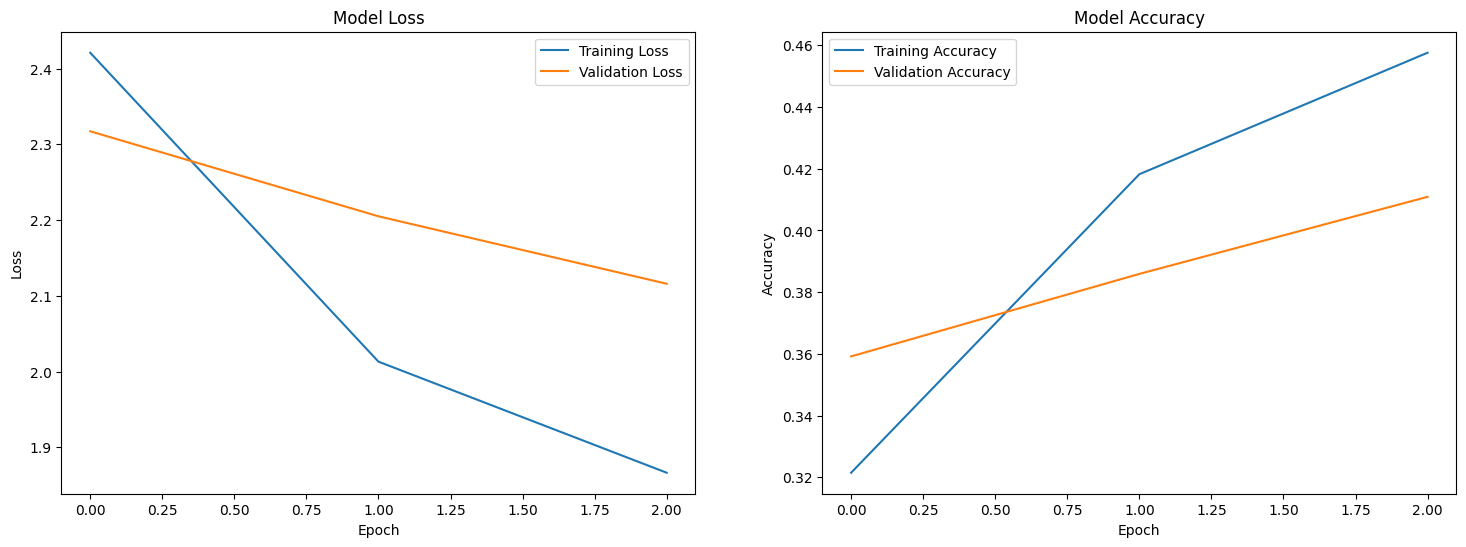

In [ ]:
train_car2car(model_3, epochs=3)

In [ ]:
def complete_sequence(input_text, models, n_grams_size, size_of_prediction):
    results = {}
    for name, model in models.items():
        encoded_input = char2int(list(input_text.lower()))

        # Pad with spaces if input is too short
        if len(encoded_input) < n_grams_size:
            padding = [reference.index(' ')] * (n_grams_size - len(encoded_input))
            encoded_input = padding + encoded_input

        # Truncate if input is too long
        if len(encoded_input) > n_grams_size:
            encoded_input = encoded_input[-n_grams_size:]

        generated_sequence = encoded_input.copy()

        for _ in range(size_of_prediction):
            input_sequence = np.array(generated_sequence[-n_grams_size:]).reshape(1, n_grams_size)
            predicted_prob = model.predict(input_sequence, verbose=0)[0]
            predicted_char_index = np.argmax(predicted_prob)
            generated_sequence.append(predicted_char_index)

        results[name] = input_text + "".join(int2char(generated_sequence[n_grams_size:]))
    return results

In [ ]:
text_to_complete = "how to flirt with Sophied the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor th"

In [ ]:
models = {"model1":model_1, "model2":model_2, "model3":model_3}

In [ ]:
complete_sequence(text_to_complete, models, 50, 100)

{'model1': 'how to flirt with Sophied the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the bottle was the same to the same to the same to the same to the same to the same to the same to the',
 'model2': 'how to flirt with Sophied the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the go',
 'model3': 'how to flirt with Sophied the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the gor the mooking the mooking the mooking the mooking the mooking the mooking the mooking the mooking the mo'}